# Introduction

Transfer learning is a well-established technique for training artificial neural networks (see e.g., Ref. [2]), which is based on the general intuition that if a pre-trained network is good at solving a given problem, then, with just a bit of additional training, it can also be used to solve a different but related problem.

As discussed in Ref. [1], this idea can be formalized in terms of two abstract networks **_A_** and **_B_**, independently from their quantum or classical physical nature.

<img src = "./img/architecture.png" height = 300px>

As sketched in the above figure, one can give the following general definition of the transfer learning method:

1. Take a network **_A_** that has been pre-trained on a dataset **_D<sub>A</sub>_** and for a given task **_T<sub>A</sub>_**.

2. Remove some of the final layers. In this way, the resulting truncated network **_A′_** can be used as a feature extractor.

3. Connect a new trainable network **_B_** at the end of the pre-trained network **_A′_**.

4. Keep the weights of **_A′_** constant, and train the final block **_B_** with a new dataset **_D<sub>B</sub>_** and/or for a new task of interest **_T<sub>B</sub>_**.

When dealing with hybrid systems, depending on the physical nature (classical or quantum) of the networks **A** and **B**, one can have different implementations of transfer learning as summarized in the following table:

| Network A | Network B | Transfer Learning Scheme                            |
| --------- | --------- | --------------------------------------------------- |
| Classical | Classical | CC - Standard classical method. See e.g., Ref. [2]. |
| Classical | Quantum   | CQ - Hybrid model presented in this tutorial.       |
| Quantum   | Classical | QC - Model studied in Ref. [1].                     |
| Quantum   | Quantum   | QQ - Model studied in Ref. [1].                     |

---

# Classical-to-Quantum Transfer Learning

We focus on the **CQ** transfer learning scheme discussed in the previous section and provide a specific example.

As pre-trained network **_A_** we use **ResNet18**, a deep residual neural network introduced by Microsoft in Ref. [3], which is pre-trained on the ImageNet dataset.

After removing its final layer we obtain **_A′_**, a pre-processing block which maps any input high-resolution image into **512 abstract features**.

Such features are classified by a 4-qubit **"dressed quantum circuit" _B_**, i.e., a variational quantum circuit sandwiched between two classical layers.

The hybrid model is trained, keeping **_A′_** constant, on the **Hymenoptera dataset** (a small subclass of ImageNet) containing images of ants and bees.

A graphical representation of the full data processing pipeline is given in the figure below.

<img src = "./img/dimensions.png" height = 100px>

---

## General Setup

> **Note**  
> To use the PyTorch interface in PennyLane, you must first install PyTorch.
>
> In addition to PennyLane, we will also need some standard PyTorch libraries and the plotting library **matplotlib**.


In [58]:
%pip install pennylane torch torchvision matplotlib

Note: you may need to restart the kernel to use updated packages.


In [59]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

# Setting of the main hyper-parameters of the model

> **Note**<br>
> To reproduce the results of Ref. [1], `num_epochs` should be set to 30 which may take a long time. We suggest to first try with `num_epochs=1` and, if everything runs smoothly, increase it to a larger value.


In [60]:
step = 0.0004               # Learning rate
batch_size = 10              # Number of samples for each training step
num_epochs = 30             # Number of training epochs

n_qubits = 4                # Number of qubits
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

We initialize a PennyLane device with a `default.qubit` backend.

This is a _noiseless_ simulator of quantum circuits.


In [61]:
dev = qml.device("default.qubit", wires=n_qubits)

We configure PyTorch to use CUDA only if available. Otherwise the CPU is used.


In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Dataset loading

> Note<br>
> The dataset containing images of ants and bees can be downloaded here and should be extracted in the subfolder `../_data/hymenoptera_data`.

This is a very small dataset (roughly 250 images), too small for training from scratch a classical or quantum model, however it is enough when using _transfer learning_ approach.

The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, etc.


In [63]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "./hymenoptera-data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let's show a batch of the test data, just to have an idea of the classification problem.


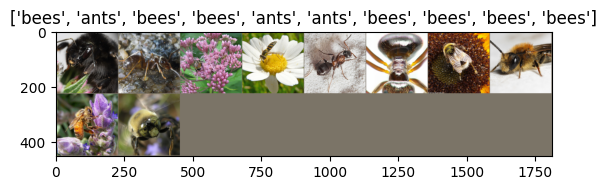

In [64]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# Variational quantum circuit

We first define some quantum layers that will compose the quantum circuit.


In [65]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

Now we define the quantum circuit through the PennyLane qnode decorator .

The structure is that of a typical variational quantum circuit:

- **Embedding layer**: All qubits are first initialized in a balanced superposition of _up_ and _down_ states, then they are rotated according to the input parameters (local embedding).

- **Variational layers**: A sequence of trainable rotation layers and constant entangling layers is applied.

- **Measurement layer**: For each qubit, the local expectation value of the **_Z_** operator is measured. This produces a classical output vector, suitable for additional post-processing.


In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

Let's visualize this.


In [90]:
# Dummy inputs
features = np.random.rand(n_qubits)
weights = np.random.rand(q_depth * n_qubits)  # Ensure weights have the correct size
weights = torch.tensor(weights, dtype=torch.float64, requires_grad=True)  # Convert to PyTorch tensor with correct dtype

# Visualize the quantum circuit at intermediate states using qml.draw()

# Initial step: Before embedding the input features
print("Quantum Circuit - Initial State (Only |+> state prepared):")
print(qml.draw(quantum_net)(np.zeros(n_qubits), weights))
print("\n")

# After embedding the input features
print("Quantum Circuit - After Embedding Input Features:")
print(qml.draw(quantum_net)(features, np.zeros(q_depth * n_qubits)))
print("\n")

# After the first variational layer
print("Quantum Circuit - After First Variational Layer:")
print(qml.draw(quantum_net)(features, weights[:n_qubits * q_depth].reshape(q_depth, n_qubits)))
print("\n")

# After the entire circuit
print("Quantum Circuit - Final State (Full Variational Circuit):")
print(qml.draw(quantum_net)(features, weights))

Quantum Circuit - Initial State (Only |+> state prepared):
0: ──H──RY(0.00)─╭●──RY(0.94)───────────╭●──RY(0.37)───────────╭●──RY(0.31)───────────╭● ···
1: ──H──RY(0.00)─╰X─╭●─────────RY(0.79)─╰X─╭●─────────RY(0.94)─╰X─╭●─────────RY(0.49)─╰X ···
2: ──H──RY(0.00)─╭●─╰X─────────RY(0.67)─╭●─╰X─────────RY(0.97)─╭●─╰X─────────RY(0.45)─╭● ···
3: ──H──RY(0.00)─╰X──RY(0.58)───────────╰X──RY(0.28)───────────╰X──RY(0.99)───────────╰X ···

0: ··· ──RY(0.18)───────────╭●──RY(0.37)───────────╭●──RY(0.54)───────────┤  <Z>
1: ··· ─╭●─────────RY(0.02)─╰X─╭●─────────RY(0.74)─╰X─╭●─────────RY(0.51)─┤  <Z>
2: ··· ─╰X─────────RY(0.49)─╭●─╰X─────────RY(0.72)─╭●─╰X─────────RY(0.64)─┤  <Z>
3: ··· ──RY(0.18)───────────╰X──RY(0.31)───────────╰X──RY(0.25)───────────┤  <Z>


Quantum Circuit - After Embedding Input Features:
0: ──H──RY(0.86)─╭●──RY(0.00)───────────╭●──RY(0.00)───────────╭●──RY(0.00)───────────╭● ···
1: ──H──RY(0.40)─╰X─╭●─────────RY(0.00)─╰X─╭●─────────RY(0.00)─╰X─╭●─────────RY(0.00)─╰X ···
2: ──H

/Users/jaimanmunshi/Desktop/VSCode-Workspace/workshops/.venv/lib/python3.13/site-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


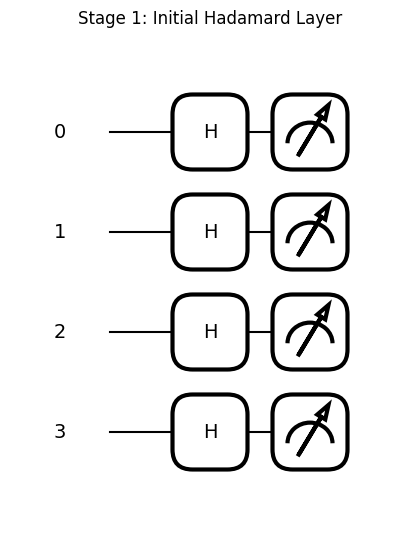

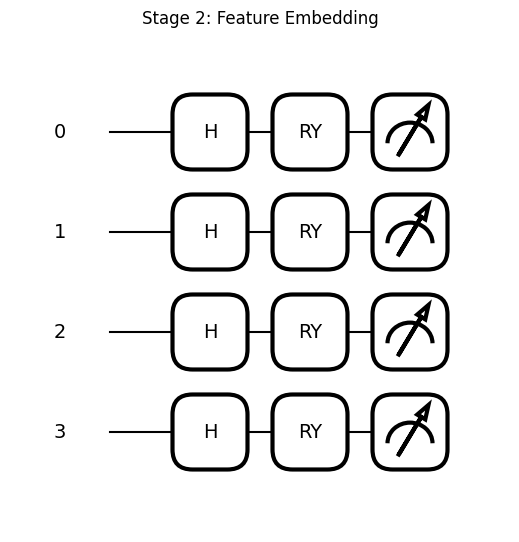

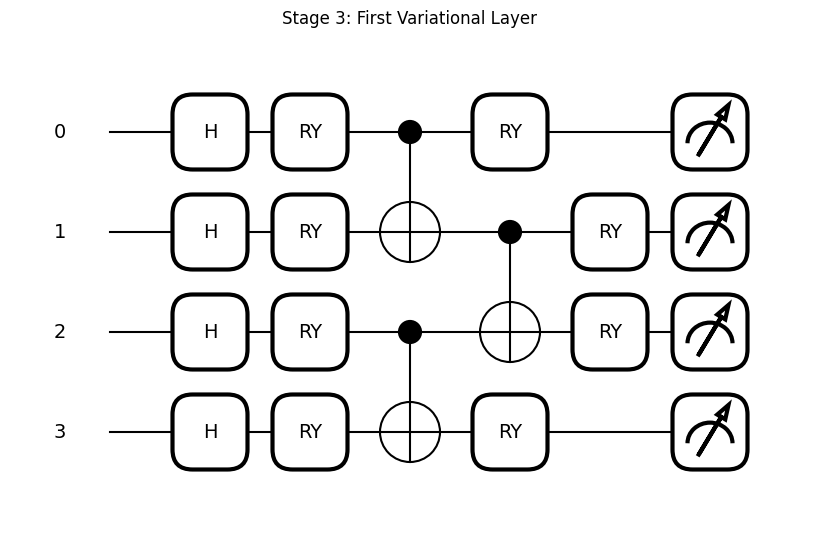

/Users/jaimanmunshi/Desktop/VSCode-Workspace/workshops/.venv/lib/python3.13/site-packages/pennylane/math/interface_utils.py:136: UserWarning: Contains tensors of types {'torch', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


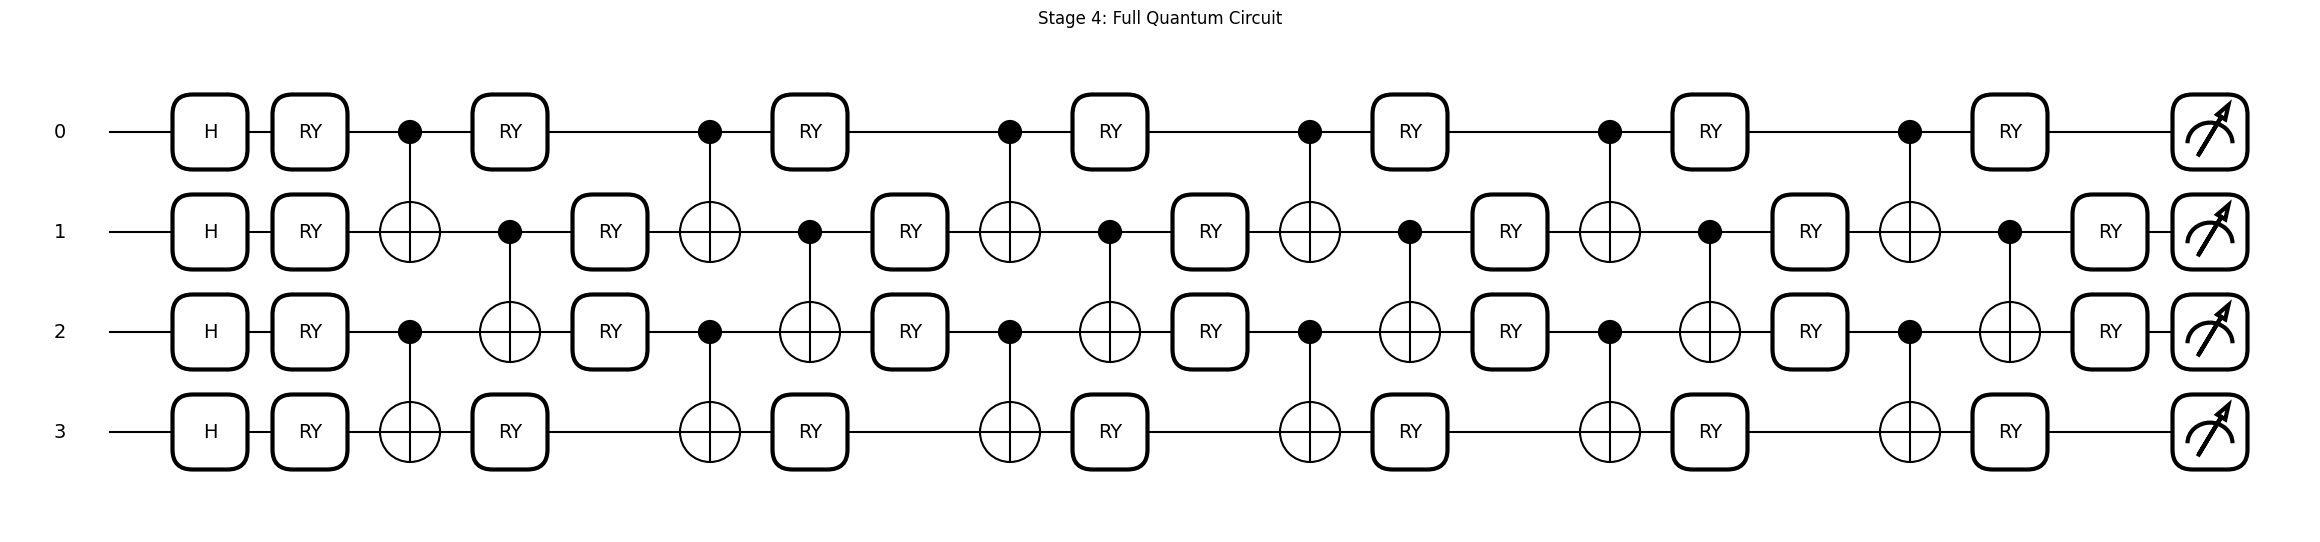

In [91]:
import matplotlib.pyplot as plt # Ensure matplotlib is imported

# Dummy inputs
features = np.random.rand(n_qubits)
weights_flat = np.random.rand(q_depth * n_qubits)
weights = weights_flat.reshape(q_depth, n_qubits)
weights_torch = torch.tensor(weights_flat, dtype=torch.float64, requires_grad=True) # Use torch tensor for consistency if needed later

# --- Stage 1: Initial Hadamard Layer ---
@qml.qnode(dev)
def circuit_stage1():
    H_layer(n_qubits)
    # Add dummy measurements for drawing if needed, or draw without them
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

fig1, ax1 = qml.draw_mpl(circuit_stage1)()
ax1.set_title("Stage 1: Initial Hadamard Layer")
plt.show()


# --- Stage 2: Feature Embedding ---
@qml.qnode(dev)
def circuit_stage2(q_input_features):
    H_layer(n_qubits)
    RY_layer(q_input_features)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

fig2, ax2 = qml.draw_mpl(circuit_stage2)(features)
ax2.set_title("Stage 2: Feature Embedding")
plt.show()


# --- Stage 3: First Variational Layer ---
@qml.qnode(dev)
def circuit_stage3(q_input_features, q_weights_layer1):
    H_layer(n_qubits)
    RY_layer(q_input_features)
    # First variational layer
    entangling_layer(n_qubits)
    RY_layer(q_weights_layer1)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

fig3, ax3 = qml.draw_mpl(circuit_stage3)(features, weights[0]) # Pass only the first layer's weights
ax3.set_title("Stage 3: First Variational Layer")
plt.show()


# --- Stage 4: Full Circuit ---
# Use the original quantum_net for the full visualization
fig4, ax4 = qml.draw_mpl(quantum_net)(features, weights_torch) # Use the original QNode
ax4.set_title("Stage 4: Full Quantum Circuit")
plt.show()

# Dressed quantum circuit

We can now define a custom `torch.nn.Module` representing a _dressed_ quantum circuit.

This is a concatenation of:

- A classical pre-processing layer (`nn.Linear`).

- A classical activation function (`torch.tanh`).

- A constant np.pi/2.0 scaling.

- The previously defined quantum circuit (`quantum_net`).

A classical post-processing layer (`nn.Linear`).

The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with two real outputs (associated with the two classes of images: _ants_ and _bees_).


In [68]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

# Hybrid classical-quantum model

We are finally ready to build our full hybrid classical-quantum network. We follow the _transfer_ learning approach:

1. First load the classical pre-trained network _ResNet18_ from the `torchvision.models` zoo.

2. Freeze all the weights since they should not be trained.

3. Replace the last fully connected layer with our trainable dressed quantum circuit (`DressedQuantumNet`).

> **Note**<br>
> The ResNet18 model is automatically downloaded by PyTorch and it may take several minutes (only the first time).


In [69]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = False


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

# Training and results

Before training the network we need to specify the _loss_ function.

We use, as usual in classification problem, the _cross-entropy_ which is directly available within `torch.nn`.


In [70]:
criterion = nn.CrossEntropyLoss()

We also initialize the Adam optimizer which is called at each training step in order to update the weights of the model.


In [71]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

We schedule to reduce the learning rate by a factor of `gamma_lr_scheduler` every 10 epochs.


In [72]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

What follows is a training function that will be called later. This function should return two things:

1. a trained model that can be used to make predictions (classifications)

2. the accuracy of the model on two datasets (training & validation) to see if our model's generalizable (can classify images we didn't use to train it).


In [73]:
# This function trains a PyTorch model and returns the best version + a training history
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()  # Record the starting time of training

    # Save the model's initial weights so we can restore the best version later
    best_model_wts = copy.deepcopy(model.state_dict())

    # Initialize variables to track the best performance
    best_acc = 0.0
    best_loss = float("inf")  # Set to a very high number initially

    # Dictionary to keep track of training and validation loss/accuracy over time
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    print("Training started:\n")

    # Loop through the number of epochs (full passes through the dataset)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")  # Print current epoch number

        # Each epoch has two phases: training and validation
        for phase in ["train", "validation"]:
            # Set the model to training mode (enables dropout, batchnorm, etc.)
            if phase == "train":
                model.train()
            # Set the model to evaluation mode (turns off dropout, batchnorm, etc.)
            else:
                model.eval()

            # Initialize loss and accuracy counters for this phase
            running_loss = 0.0
            running_corrects = 0

            # Loop over the batches of data
            for inputs, labels in dataloaders[phase]:
                # Move inputs and labels to the GPU (or CPU) device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the gradients so we don't accumulate from previous steps
                optimizer.zero_grad()

                # Enable gradient tracking only in the training phase
                with torch.set_grad_enabled(phase == "train"):
                    # Forward pass: get model predictions
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)  # Get predicted class
                    loss = criterion(outputs, labels)  # Calculate loss

                    # Backward pass + optimize only if in training phase
                    if phase == "train":
                        loss.backward()      # Compute gradients
                        optimizer.step()     # Update weights

                # Accumulate loss and correct predictions for the entire phase
                running_loss += loss.item() * inputs.size(0)  # Multiply by batch size
                running_corrects += torch.sum(preds == labels.data).item()

            # Calculate average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            # Print the results for this phase
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Save metrics to history and step the scheduler if training
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
                scheduler.step()  # Adjust learning rate
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)

                # Save the model if this is the best validation accuracy so far
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    # Print total training time
    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.4f}")

    # Load the best model weights into the model before returning
    model.load_state_dict(best_model_wts)
    return model, history  # Return the best model and the training history

We are ready to perform the actual training process and store the generalization data.


In [74]:
model_hybrid, history = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:

Epoch 1/30
Train Loss: 0.7009 Acc: 0.5205
Validation Loss: 0.6579 Acc: 0.6536
Epoch 2/30
Train Loss: 0.6294 Acc: 0.6721
Validation Loss: 0.5832 Acc: 0.7516
Epoch 3/30
Train Loss: 0.5623 Acc: 0.7787
Validation Loss: 0.5435 Acc: 0.7908
Epoch 4/30
Train Loss: 0.5107 Acc: 0.8115
Validation Loss: 0.4437 Acc: 0.8431
Epoch 5/30
Train Loss: 0.3998 Acc: 0.9057
Validation Loss: 0.4340 Acc: 0.8562
Epoch 6/30
Train Loss: 0.4012 Acc: 0.8893
Validation Loss: 0.3920 Acc: 0.8758
Epoch 7/30
Train Loss: 0.3413 Acc: 0.9303
Validation Loss: 0.3620 Acc: 0.8627
Epoch 8/30
Train Loss: 0.3441 Acc: 0.9221
Validation Loss: 0.3453 Acc: 0.8758
Epoch 9/30
Train Loss: 0.3349 Acc: 0.9221
Validation Loss: 0.3184 Acc: 0.9085
Epoch 10/30
Train Loss: 0.3111 Acc: 0.9221
Validation Loss: 0.3012 Acc: 0.9216
Epoch 11/30
Train Loss: 0.3003 Acc: 0.9385
Validation Loss: 0.3015 Acc: 0.9085
Epoch 12/30
Train Loss: 0.3224 Acc: 0.9016
Validation Loss: 0.3167 Acc: 0.8889
Epoch 13/30
Train Loss: 0.2976 Acc: 0.9262

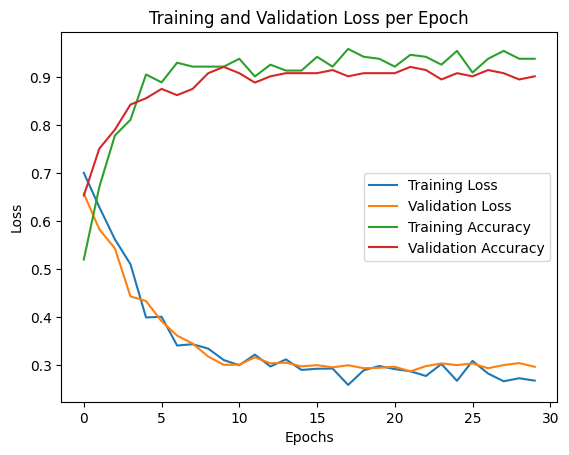

In [78]:
# Plot training and validation loss
plt.figure("Training and Validation Loss")
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.plot(history["train_acc"], label="Training Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.show()

# Visualizing the model Predications

We first define a visualization function for a batch of test data.


In [76]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

Finally, we can run the previous function to see a batch of images with the corresponding predictions.


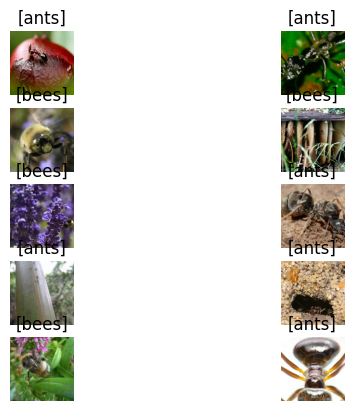

In [77]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()

# References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. Transfer learning in hybrid classical-quantum neural networks. arXiv:1912.08278 (2019).

[2] Rajat Raina, Alexis Battle, Honglak Lee, Benjamin Packer, and Andrew Y Ng. Self-taught learning: transfer learning from unlabeled data. Proceedings of the 24th International Conference on Machine Learning\*, 759–766 (2007).

[3] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. Deep residual learning for image recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016).

[4] Ville Bergholm, Josh Izaac, Maria Schuld, Christian Gogolin, Carsten Blank, Keri McKiernan, and Nathan Killoran. PennyLane: Automatic differentiation of hybrid quantum-classical computations. arXiv:1811.04968 (2018).

[5] Andrea Mari. Quantum Transfer Learning. https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning (2024)
